## Milne-Eddington Inversions of a GRIS dataset

Now we are going to try to interpret a similar dataset as a HINODE one, but there are some differences: 

1) Spectral lines are different. Instead of 6300 lines, we are using lines around 1.56 micron. Can someone tell us why these would be interesting? 

2) The observations are obtained from the ground. In a way that makes them more similar to DKIST ones. However, this specific line is not observable from the DKIST at the moment

3) We will take into account something called spectral PSF. You should have heard something about it from Valentin the lecture before. 

Well, let's dive right in! 

In [2]:
# Our good old packages for inversion, numerical manipulation and plotting...
import MilneEddington 
import numpy as np
import matplotlib.pyplot as plt

# You might remember this one, this allows us to load fits files into numpy arrays
from astropy.io import fits

In [3]:
#Load the data
stokes = fits.open('/home/milic/scratch/gris_20170903_006/l1_data/20170903_sunspot.fits')[0].data

In [4]:
stokes.shape

(433, 500, 4, 1010)

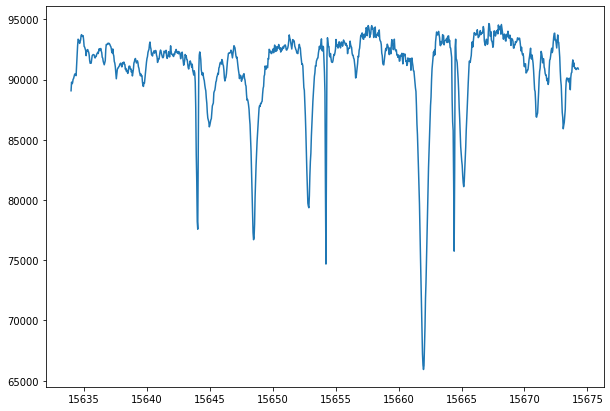

In [5]:
# Note that the number of wavelengths is now much larger than before

# We are again going to give you wavelengts from the top of the head ;) 
# But they can be found if you look at the individual GRIS fits file
ll = np.arange(1010)*0.039956 + 15633.967

# Let's first look at the mean spectrum:

mean_spectrum = np.mean(stokes,axis=(0,1))
plt.figure(figsize=[10,7])
plt.plot(ll,mean_spectrum[0])



#### There are some things to point out here:

1) The spectrum is much "uglier" than HINODE one, there is a lot of noise-like oscillations (these are the so called fringes), level is uneven it is hard to say what the continuum is 

2) There are many lines, some of these are well known 1.56 micron Iron lines, some are perhaps unidentified, some (the narrow ones), are the so called telluric lines 

3) The lines are much weaker, it might not be clear from the first plot, but now we are going to focus on one part of the spectrum and normalize properly...

(0.0, 1.1)

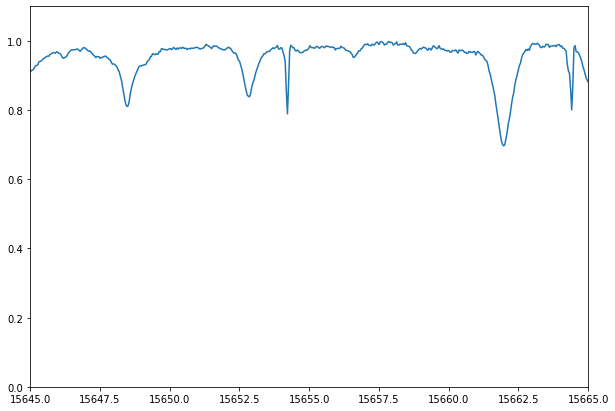

In [6]:
# We will normalize slightly differently than before
qs = np.max(mean_spectrum[0])
stokes /= qs
mean_spectrum /= qs
mean_spectrum = np.mean(stokes,axis=(0,1))
plt.figure(figsize=[10,7])
plt.plot(ll,mean_spectrum[0])
plt.xlim([15645.,15665.,]) # angstroms 
plt.ylim([0.0,1.1])


Now the story looks much more different! Let's focus on the line around 15648 (do you know why?) and plot some polarized spetra and some images. 

Line should be around :  364.22564821303143


(0.0, 1.1)

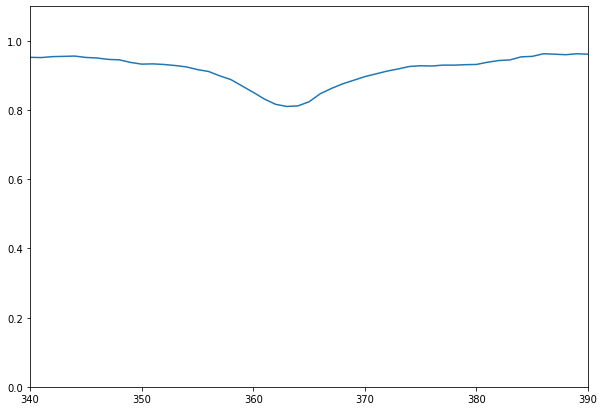

In [7]:
# First, let's isolate the wavelenghts indices where this line is:
print ('Line should be around : ',(15648.52 - 15633.967) /0.039956)
plt.figure(figsize=[10,7])
plt.plot(mean_spectrum[0])
plt.xlim([340,390]) # indices 
plt.ylim([0.0,1.1])

(15646.5, 15650.5)

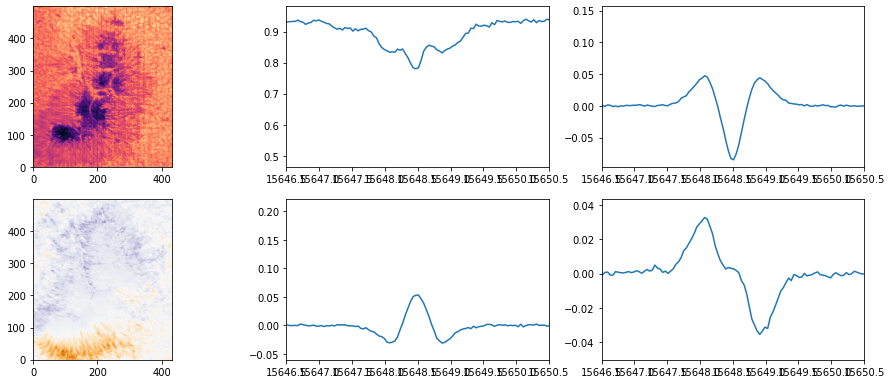

In [8]:
# Let's plot one example Stokes profile (100,200 is our lucky pixel ).
# We know stokes should be strong in the wing of the line, so let's say index 359
i=100
j=200
plt.figure(figsize=[16,6.5])
plt.subplot(231)
plt.imshow(stokes[:,:,0,0].T,origin='Lower',cmap='magma')
plt.subplot(234)
plt.imshow(stokes[:,:,3,358].T,origin='Lower',cmap='PuOr',vmin=-0.1,vmax=0.1)
plt.subplot(232)
plt.plot(ll,stokes[i,j,0])
plt.xlim([15646.5,15650.5])
plt.subplot(233)
plt.plot(ll,stokes[i,j,1])
plt.xlim([15646.5,15650.5])
plt.subplot(235)
plt.plot(ll,stokes[i,j,2])
plt.xlim([15646.5,15650.5])
plt.subplot(236)
plt.plot(ll,stokes[i,j,3])
plt.xlim([15646.5,15650.5])


### Nice, te story is similar to what we saw before with HINODE! We are almost ready to invert the line.

There are two additions tho, the first one is we need to add the atomic information of this line to the config file...

Let's go to the file where all the line info is hard-coded and add this specific line....

:Meddles in terminal for a bit......

........


........

The second one is that we are going to add the so called spectral psf, that is, we will account for the mixing between the wavelenghts due to the instrumental effects (Valentin's lecture)

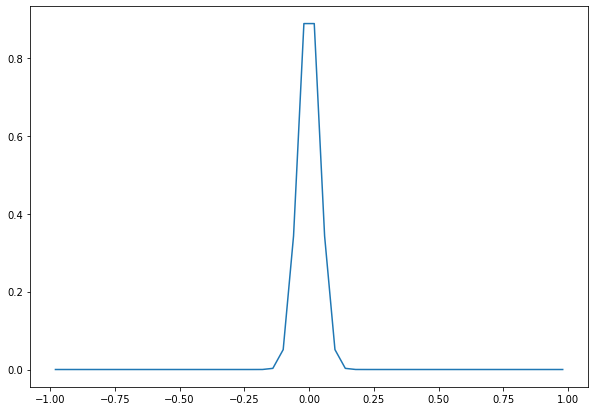

In [9]:
# Let's restrict our wavelength: 
ll = ll[340:390]
# Spectral resolution of this instrument is: 115000 (Can becheked)
# It means that the full-wdith half-maximum of this is: 
FWHM = 15650. / 115000. 
# And then we can use an approximation that this corresponds to a gaussian with width of FWHM / 2.35
sigma = FWHM/2.35
center = np.mean(ll)
psf = np.exp(-(ll-center)**2.0/sigma**2.0)

plt.figure(figsize=[10,7])
plt.plot(ll-center,psf)



In [10]:
regions = [[ll, psf/psf.sum()]]

# These are the lines
lines   = [15648]

# Looks like we got everything
me = MilneEddington.MilneEddington(regions, lines, nthreads=1)

#Finally let's also restrict our stokes vector to the same wavelengths:
stokes = stokes[:,:,:,340:390]

In [11]:
# We learned yesterday that we need an estimate of the error uncertanties, we need to specify the noise
noise_level = 1.e-3
noise = np.zeros((4, me.get_wavelength_array().size), dtype='float64', order='c')
noise += noise_level
noise[0] *= 10. #noise is typicaly larger for I, because of systematics - Discuss!

In [12]:
# We are going to get used to deal with number of pixels, so here are some new variables for you :)
nx = 1
ny = 1
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])

# This creates nx x ny clones of model_guess
models_guess  = me.repeat_model(model_guess, nx, ny)

# What are we fitting, one Stokes profile, but remember the form it has to go in (nx x ny x 4 x n_lambda)
to_fit = stokes[i,j].reshape(1,1,4,50)
    
#
# This is where the inversion happens:
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 20, nIter=100, chi2_thres=1.0, verbose=False)


In [13]:
# Let's, for the sanity's sake, print out the quantities:
print ('Model parameters :', model_out)
print ('Chi-squared = ',chi2)

Model parameters : [[[ 1.25089405e+03  1.27610786e+00  2.85548011e+00 -7.17671776e-01
    1.24853904e-01  1.28646841e+00  1.67380263e-01  4.70793608e-01
    4.25170541e-01]]]
Chi-squared =  [[65.02543561]]


Aaaand, let's plot!

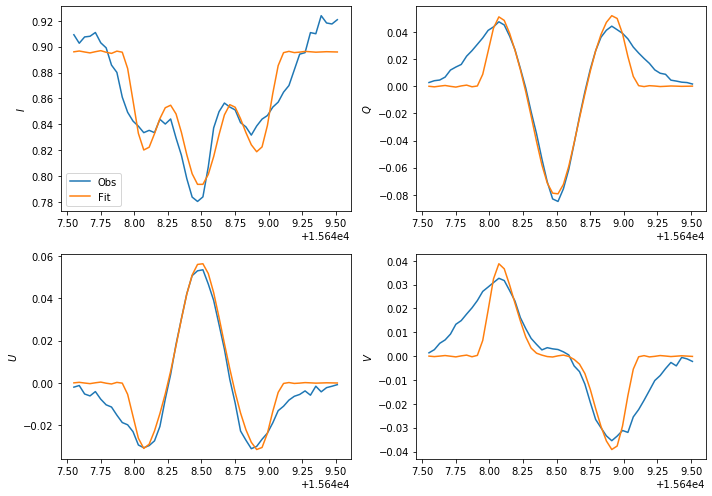

In [14]:
#test the plot
plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(ll[:60],to_fit[0,0,0],label='Obs')
plt.plot(ll[:60],syn_out[0,0,0],label='Fit')
plt.ylabel("$I$")
plt.legend()
plt.subplot(222)
plt.plot(ll[:60],to_fit[0,0,1],label='Obs')
plt.plot(ll[:60],syn_out[0,0,1],label='Fit')
plt.ylabel("$Q$")
plt.subplot(223)
plt.plot(ll[:60],to_fit[0,0,2],label='Obs')
plt.plot(ll[:60],syn_out[0,0,2],label='Fit')
plt.ylabel("$U$")
plt.subplot(224)
plt.plot(ll[:60],to_fit[0,0,3],label='Obs')
plt.plot(ll[:60],syn_out[0,0,3],label='Fit')
plt.ylabel("$V$")
plt.tight_layout()

Does not look that good, but it is still probably acceptable. There are a lot of effects we are missing here! 

In [15]:
# First part is to make use of the parallel capabilities of modern processors and do this with
# multiple threads
me = MilneEddington.MilneEddington(regions, lines, nthreads=8)

pyMilne::dealloc: cleaning-up...


In [16]:
%%time 
# This will tell us how much time we use

# Now we are going to select a region:
i = 0 # we start from here
j = 0 
nx = 200 # and take this big chunk
ny = 200

# The same as before
model_guess = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0])
# Now we have 200 x 200 clones. In principle they don't have to be the same! 
models_guess  = me.repeat_model(model_guess, nx, ny)

# Select a Stokes subset to fit:
to_fit = stokes[i:i+nx,j:j+ny,:,:].reshape(nx,ny,4,50)

# This is where the inversion happens, be mindful it will take some time
#
model_out, syn_out, chi2 = me.invert(models_guess, to_fit, noise, nRandom = 20, nIter=50, chi2_thres=1.0, verbose=False)

CPU times: user 21min 27s, sys: 713 ms, total: 21min 28s
Wall time: 6min 7s


In [17]:
print(model_out.shape)
print(chi2.shape)
#model_out = model_out.reshape(nx,ny,9)

(200, 200, 9)
(200, 200)


As previously, let's start by plotting $\chi^2$ map:

In [ ]:
plt.figure(figsize=[10,7])
plt.imshow(chi2.T,cmap='cividis',origin='lower')
plt.title("$\chi^2$")
plt.colorbar()
plt.tight_layout()

In [ ]:
import imtools as im
psf = im.gauss2d(45,15)
psf /= psf.sum()
    
for ii in range(9):
    model_out[:,:,ii] = im.fftconvol2d(model_out[:,:,ii], psf)

#
# Run second cycle, starting from the smoothed guessed model
#
model_out, syn_out, chi2 = me.invert(model_out, to_fit, noise, nRandom = 20, nIter=50, chi2_thres=1.0, verbose=False)

Not bad, not bad. Seems like most of the pixels have $\chi^2$ of a few, while some number of pixels has somewhat larger values. 

Probably nothing to be worried about as we already know that our model is, striclty speaking, not correct! 

Velocity gradients, magnetic field gradients and other intricancies of radiative transfer lead to the departures. 

Now, let's plot some parameter maps:

In [ ]:
# The easiest sanity check for this is the velocity:
# Velocity is often normalized w.r.t the mean value 
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,3].T,cmap='bwr',origin='lower')
plt.title("Los velocity")
plt.colorbar()
plt.tight_layout()

Looks good! We see some structure on granular scale, and so on, let's look at the magnetic field strength:

In [ ]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,0].T,cmap='cividis',origin='lower',vmin=0,vmax=2500)
plt.title("Magnetic field")
plt.colorbar()
plt.tight_layout()

Interesting! We see a magnetic field structure that would perhaps resemble something as "network".
Even more interesting, the magnetic field structure corresponds to bad fits. Can you think why that is?

In [ ]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,1].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field inclination")
plt.colorbar()
plt.tight_layout()

Here we, for the first time, see an interesting effect - salt and pepper noise. Namely, at some points magnetic field is so low that we cannot really judge the inclination so well. Actually, there is a very good reason why in the most non-magnetic pixels, inclination is close to 90... Can you think of that? 

In [ ]:
plt.figure(figsize=[10,7])
plt.imshow(model_out[:,:,2].T*180./np.pi,cmap='PuOr',origin='lower')
plt.title("Field azimuth")
plt.colorbar()
plt.tight_layout()

This is now a complete mess! Excet for the network regions. Can you explain why? 

### Things to follow up with: 

1) Inversion with the other line 

2) Inversion with both the lines 

3) Further changing the weights 

4) Changing number of iterations, etc. 


In [ ]:
# You might want to save these results for future use, to save a .fits file of the inverted parameters

# you can do something like this 
myhdu = fits.PrimaryHDU(model_out)
myhdu.writeto("inverted_models.fits",overwrite=True)